In [1]:
import json
from utils.OpenMeteoWeather import OpenMeteoWeather
from utils.Copernicus import AdvancedCopernicus
from utils.PlanetPositions import PlanetPositions

output_filename = "output.nc"
start_datetime = "2023-09-01T00:00:00Z"
end_datetime = "2025-02-01T00:00:00Z"

latitude = 54.793
longitude = 9.441
val_range = 0.5

minimum_latitude = latitude - val_range
maximum_latitude = latitude + val_range
minimum_longitude = longitude - val_range
maximum_longitude = longitude + val_range



ac = AdvancedCopernicus()

ac_data = ac.get_subset(
                dataset_id="cmems_mod_glo_phy_anfc_0.083deg_PT1H-m",
                dataset_version="202406",
                variables=["so", "thetao", "vo", "zos", "uo"], 
                minimum_longitude=minimum_longitude,
                maximum_longitude=maximum_longitude,
                minimum_latitude=minimum_latitude,
                maximum_latitude=maximum_latitude,
                start_datetime=start_datetime,
                end_datetime=end_datetime,
                minimum_depth=0.49402499198913574,
                maximum_depth=0.49402499198913574,
                coordinates_selection_method="strict-inside",
                disable_progress_bar=False,
                output_filename=output_filename
                )
ac.delete_dataset(output_filename)

# convert datetime to YYYY-MM-DD
start_datetime = start_datetime.split("T")[0]
end_datetime = end_datetime.split("T")[0]



omw = OpenMeteoWeather(latitude=latitude, 
                       longitude=longitude, 
                       start_date=start_datetime, 
                       end_date=end_datetime)
df_omw = omw.get_weather_dataframe(archive=True)





INFO - 2025-02-14T22:21:53Z - Selected dataset version: "202406"
INFO - 2025-02-14T22:21:53Z - Selected dataset part: "default"
INFO - 2025-02-14T22:21:59Z - Starting download. Please wait...


  0%|          | 0/40 [00:00<?, ?it/s]

INFO - 2025-02-14T22:22:26Z - Successfully downloaded to output.nc


In [2]:
pp = PlanetPositions(start_date=start_datetime, stop_date=end_datetime, step='1h')
pp.fetch_data()
pp.convert_time()
df_planet = pp.get_dataframe()

# convert colum datetime to YYYY-MM-DD HH:MM:SS
df_planet['datetime'] = df_planet['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')
display(df_planet.head())

,targetname,datetime_str,x,y,z,vx,vy,vz,lighttime,range,range_rate,planet,datetime
0,Mercury (199),A.D. 2023-Sep-01 00:00:00.0000,0.317508,-0.249851,-0.049541,0.011847,0.023419,0.000827,0.002351,0.407052,-0.005234,Mercury,2023-09-01 02:00:00
1,Mercury (199),A.D. 2023-Sep-01 01:00:00.0000,0.318001,-0.248875,-0.049507,0.011789,0.023465,0.000836,0.002350,0.406834,-0.005241,Mercury,2023-09-01 03:00:00
2,Mercury (199),A.D. 2023-Sep-01 02:00:00.0000,0.318491,-0.247896,-0.049472,0.011731,0.023510,0.000845,0.002348,0.406615,-0.005247,Mercury,2023-09-01 03:59:59
3,Mercury (199),A.D. 2023-Sep-01 03:00:00.0000,0.318978,-0.246916,-0.049436,0.011672,0.023555,0.000854,0.002347,0.406397,-0.005254,Mercury,2023-09-01 05:00:00
4,Mercury (199),A.D. 2023-Sep-01 04:00:00.0000,0.319463,-0.245933,-0.049400,0.011614,0.023601,0.000863,0.002346,0.406178,-0.005260,Mercury,2023-09-01 06:00:00


In [3]:
# to dataframe
df_ac = ac_data.to_dataframe().reset_index().dropna(axis=0, how='any')
#display(df_ac.head())
# convert datetime to YYYY-MM-DD HH:MM:SS
df_ac["time"] = df_ac["time"].dt.strftime('%Y-%m-%d %H:%M:%S')

df_ac_grouped = df_ac.groupby("time").mean().reset_index()
display(df_ac_grouped.head())

,time,depth,latitude,longitude,so,thetao,vo,zos,uo
0,2023-09-01 00:00:00,0.494025,54.961117,9.663894,15.823148,18.588573,-0.025500,-0.172032,0.015157
1,2023-09-01 01:00:00,0.494025,54.961117,9.663894,15.824436,18.564545,-0.040431,-0.176850,0.014370
2,2023-09-01 02:00:00,0.494025,54.961117,9.663894,15.825871,18.540257,-0.048652,-0.174927,0.010975
3,2023-09-01 03:00:00,0.494025,54.961117,9.663894,15.827270,18.517294,-0.050082,-0.168681,0.007156
4,2023-09-01 04:00:00,0.494025,54.961117,9.663894,15.828256,18.495977,-0.048655,-0.164178,0.006391


In [4]:
# convert date to YYYY-MM-DD HH:MM:SS
df_omw["date"] = df_omw["date"].dt.strftime('%Y-%m-%d %H:%M:%S')
df_omw.groupby("date").mean().reset_index()
display(df_omw.head())

,date,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation_probability,precipitation,rain,showers,snowfall,...,temperature_180m,soil_temperature_0cm,soil_temperature_6cm,soil_temperature_18cm,soil_temperature_54cm,soil_moisture_0_to_1cm,soil_moisture_1_to_3cm,soil_moisture_3_to_9cm,soil_moisture_9_to_27cm,soil_moisture_27_to_81cm
0,2023-08-31 23:00:00,13.4515,89.160789,11.7015,12.218298,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-09-01 00:00:00,13.1515,94.275848,12.2515,12.332190,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-09-01 01:00:00,12.6515,94.565475,11.8015,12.050385,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-09-01 02:00:00,12.1015,94.856232,11.3015,11.494043,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-09-01 03:00:00,11.8015,95.159622,11.0515,11.108099,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# merge dataframes
df_merged = df_ac_grouped.merge(df_omw, left_on="time", right_on="date").drop(columns=["date"]).merge(df_planet, left_on="time", right_on="datetime")
df_merged.dropna(axis=1, how='any', inplace=True)
display(df_merged.head())

,time,depth,latitude,longitude,so,thetao,vo,zos,uo,temperature_2m,...,y,z,vx,vy,vz,lighttime,range,range_rate,planet,datetime
0,2023-09-01 02:00:00,0.494025,54.961117,9.663894,15.825871,18.540257,-0.048652,-0.174927,0.010975,12.1015,...,-0.249851,-0.049541,0.011847,0.023419,0.000827,0.002351,0.407052,-0.005234,Mercury,2023-09-01 02:00:00
1,2023-09-01 02:00:00,0.494025,54.961117,9.663894,15.825871,18.540257,-0.048652,-0.174927,0.010975,12.1015,...,-0.132017,-0.042999,0.003580,0.019798,0.000065,0.004200,0.727180,-0.000084,Venus,2023-09-01 02:00:00
2,2023-09-01 02:00:00,0.494025,54.961117,9.663894,15.825871,18.540257,-0.048652,-0.174927,0.010975,12.1015,...,-0.378138,0.000016,0.006163,0.015879,-0.000001,0.005830,1.009392,-0.000234,Earth,2023-09-01 02:00:00
3,2023-09-01 02:00:00,0.494025,54.961117,9.663894,15.825871,18.540257,-0.048652,-0.174927,0.010975,12.1015,...,-0.488093,0.027765,0.004728,-0.012152,-0.000371,0.009381,1.624240,-0.000863,Mars,2023-09-01 02:00:00
4,2023-09-01 02:00:00,0.494025,54.961117,9.663894,15.825871,18.540257,-0.048652,-0.174927,0.010975,12.1015,...,2.806554,-0.103274,-0.004358,0.006586,0.000070,0.028678,4.965428,0.000127,Jupiter,2023-09-01 02:00:00


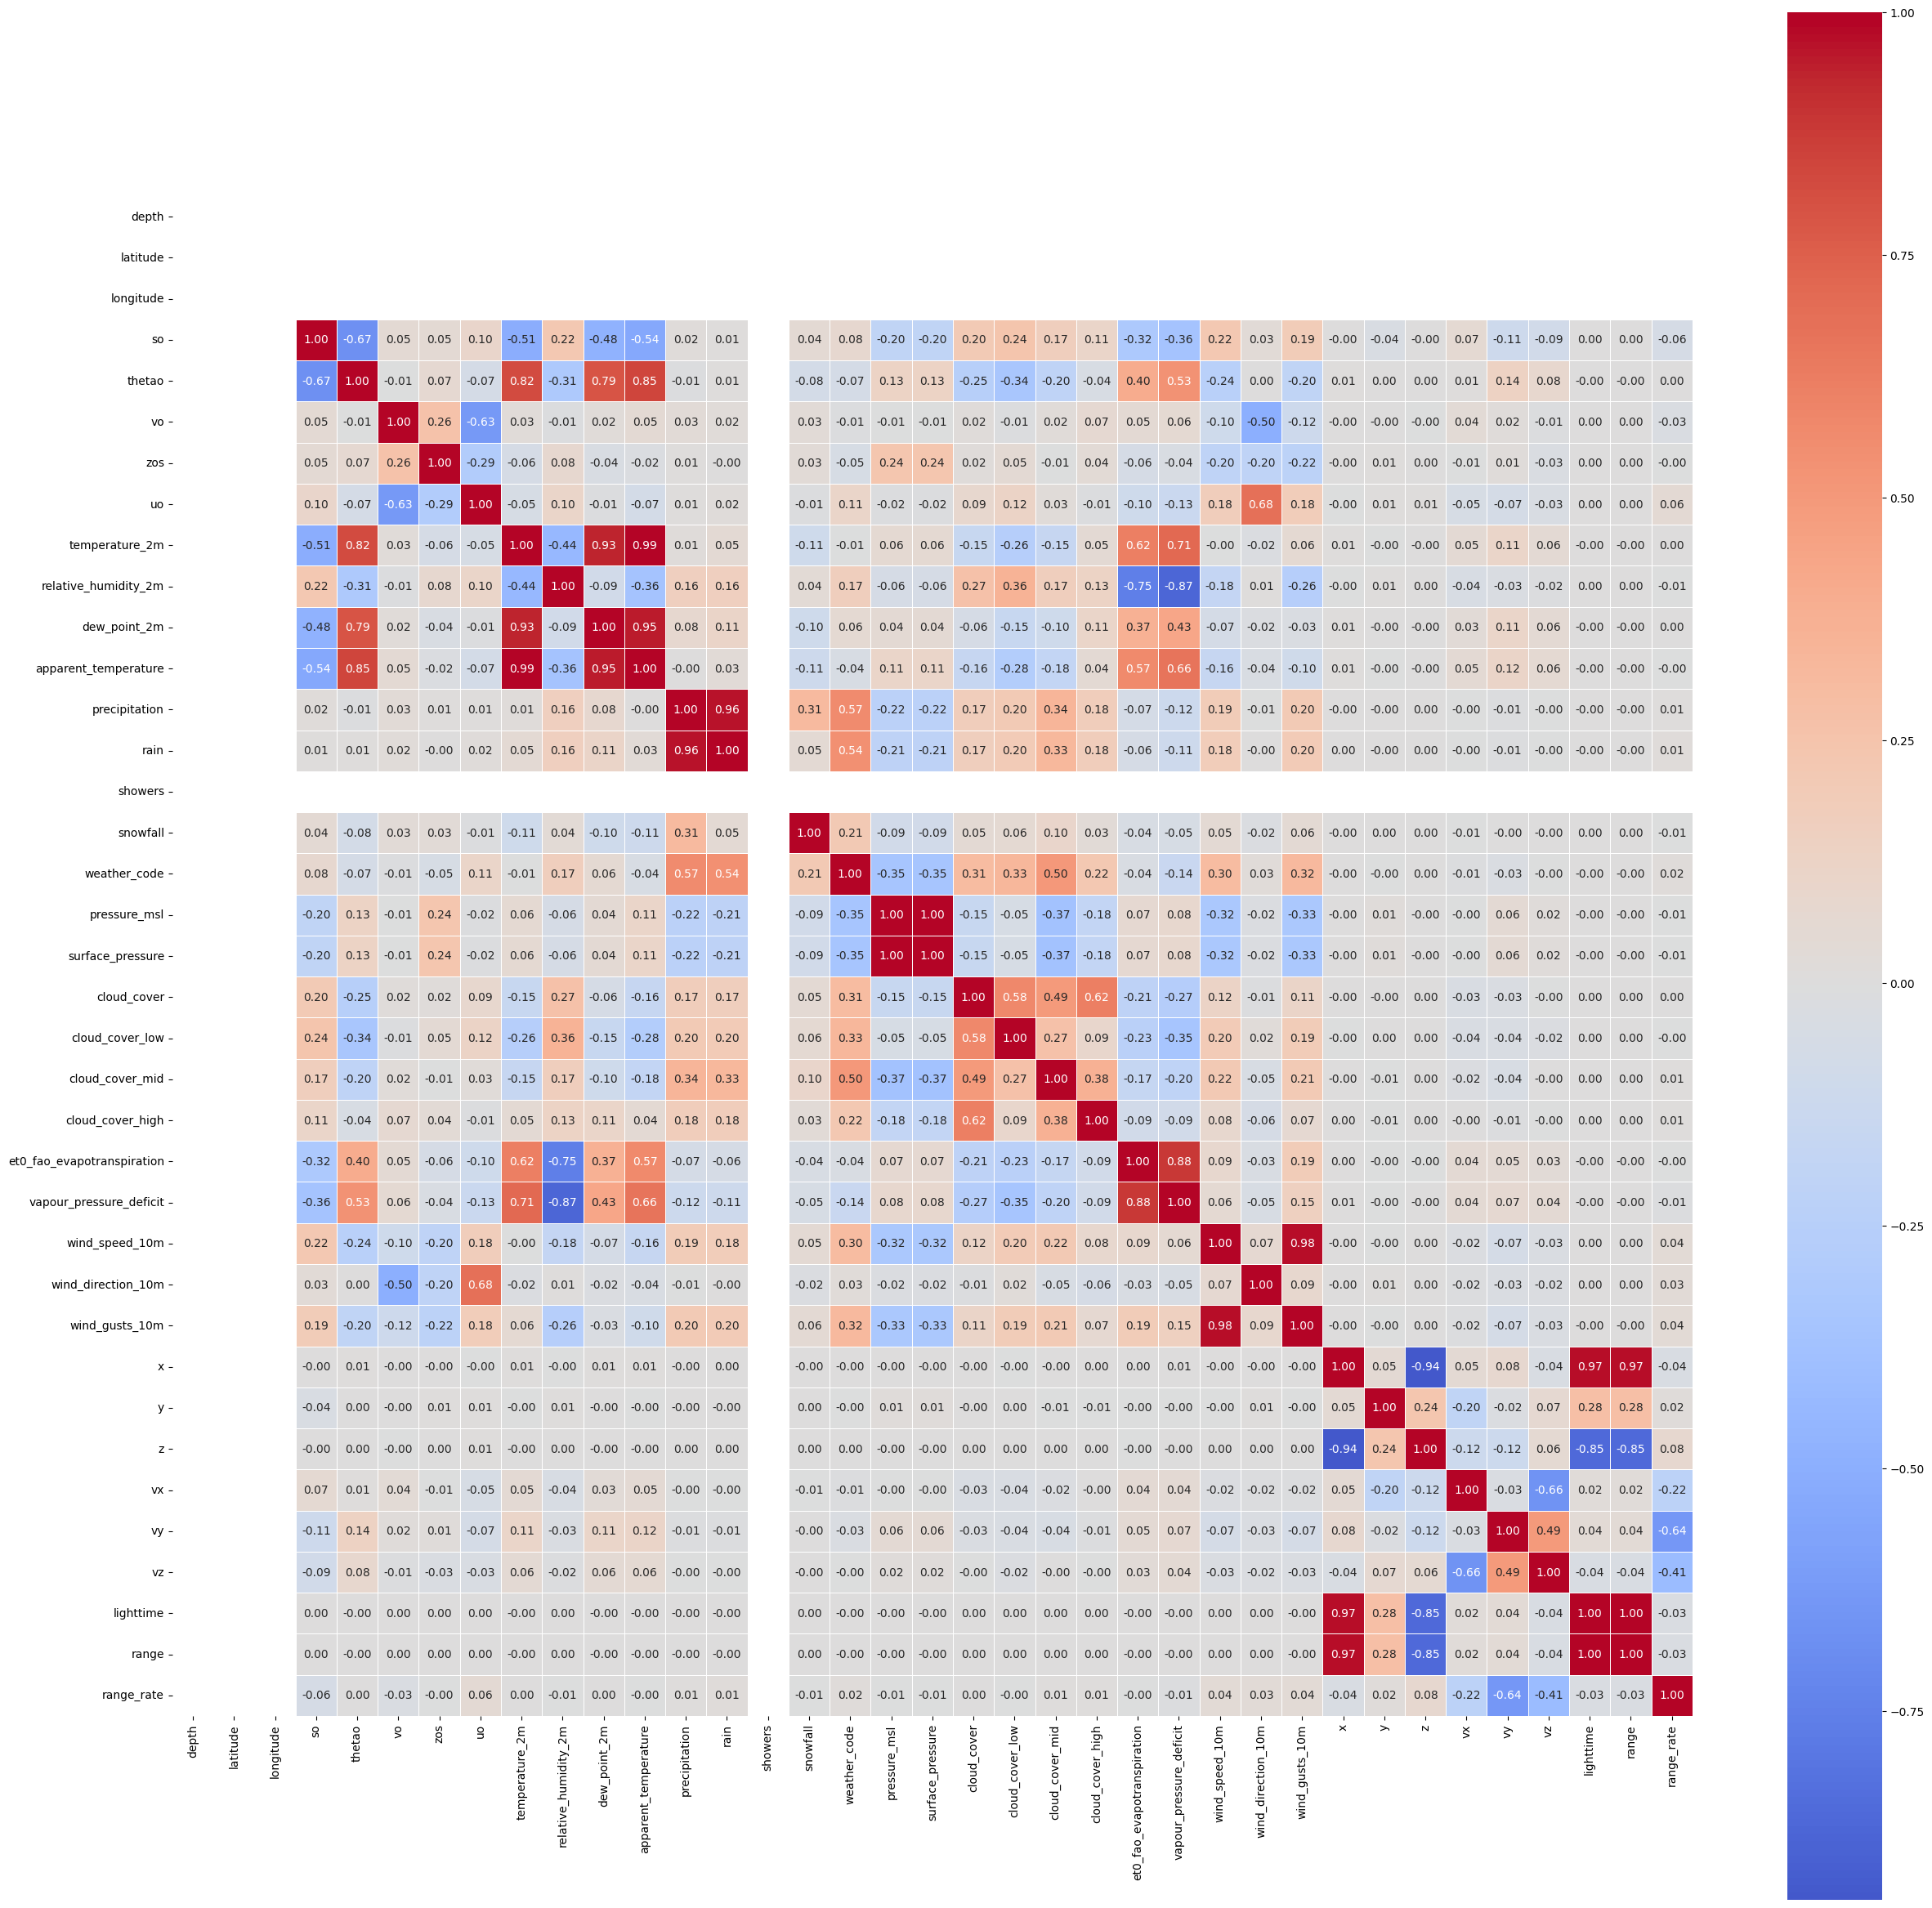

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
# plot correlation
corr = df_merged.corr(numeric_only=True)

plt.figure(figsize=(30, 30))

# pallette = sns.diverging_palette(220, 20, n=7)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True, linewidths=.5)
plt.show()



<Axes: xlabel='time', ylabel='zos'>

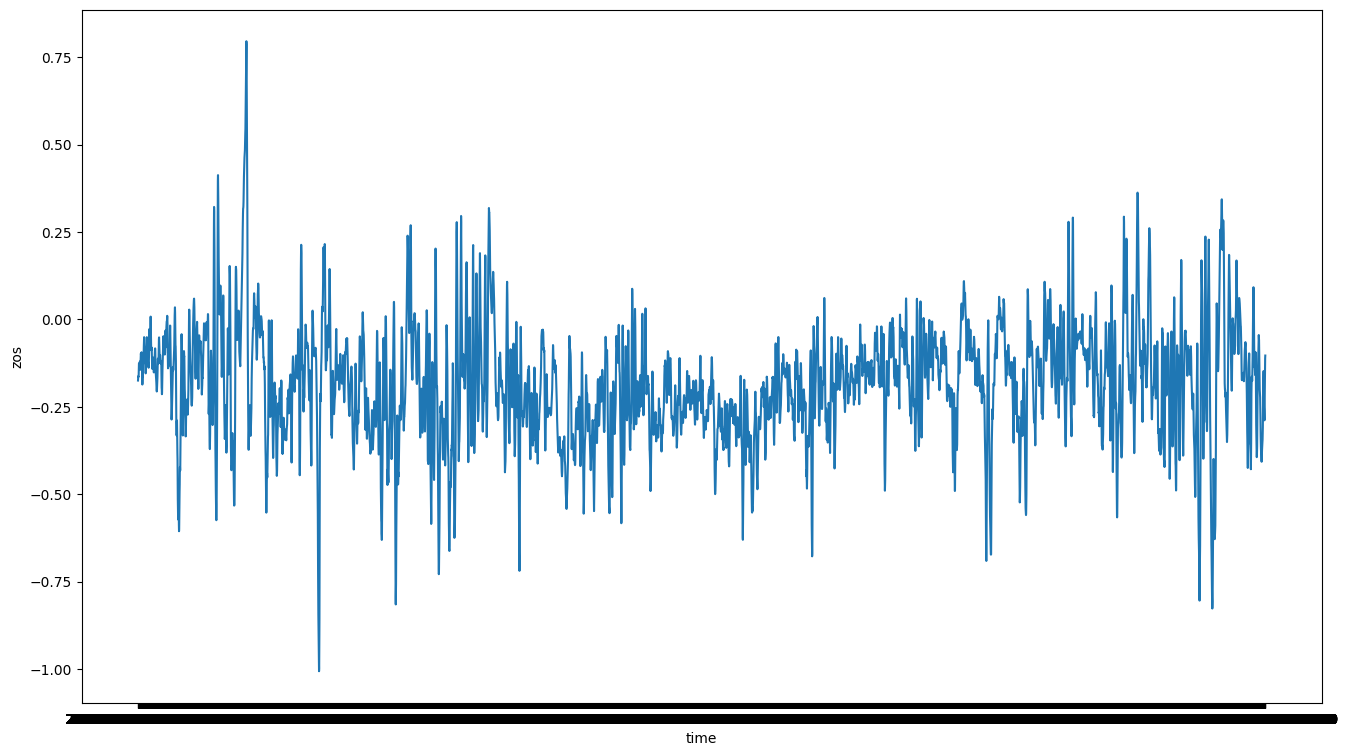

In [7]:
df_plot = df_merged.groupby("time").mean(numeric_only=True).reset_index()

plt.figure(figsize=(16, 9))
sns.lineplot(data=df_plot, x="time", y="zos")
plt.show()

In [8]:
df = df_merged.drop(columns=["time"])

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np

# # Dummy DataFrame (ersetzen mit echtem Datensatz)
features = ['depth', 'latitude', 'longitude', 'so', 'thetao', 'vo', 'uo', 'temperature_2m', 
            'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature', 'precipitation_probability',
            'precipitation', 'rain', 'showers', 'snowfall', 'snow_depth', 'weather_code',
            'pressure_msl', 'surface_pressure', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 
            'cloud_cover_high', 'visibility', 'evapotranspiration', 'et0_fao_evapotranspiration', 
            'vapour_pressure_deficit', 'wind_speed_10m', 'wind_speed_80m', 'wind_speed_120m', 'wind_speed_180m',
            'wind_direction_10m', 'wind_direction_80m', 'wind_direction_120m', 'wind_direction_180m', 
            'wind_gusts_10m', 'temperature_80m', 'temperature_120m', 'temperature_180m', 'soil_temperature_0cm',
            'soil_temperature_6cm', 'soil_temperature_18cm', 'soil_temperature_54cm', 'soil_moisture_0_to_1cm',
            'soil_moisture_1_to_3cm', 'soil_moisture_3_to_9cm', 'soil_moisture_9_to_27cm', 'soil_moisture_27_to_81cm']

# df = pd.DataFrame(np.random.rand(10000, len(features) + 1), columns=features + ['zos'])

# Daten vorbereiten
X = torch.tensor(df[features].values, dtype=torch.float32)
y = torch.tensor(df['zos'].values, dtype=torch.float32).view(-1, 1)

# Train-Test Split
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Neuronales Netzwerk definieren
class ZOSPredictor(nn.Module):
    def __init__(self, input_dim):
        super(ZOSPredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# Modell initialisieren
model = ZOSPredictor(input_dim=len(features))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")

# Evaluierung
model.eval()
total_loss = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        total_loss += loss.item()

print(f"Test Loss: {total_loss/len(test_loader):.4f}")


KeyError: "['precipitation_probability', 'snow_depth', 'visibility', 'evapotranspiration', 'wind_speed_80m', 'wind_speed_120m', 'wind_speed_180m', 'wind_direction_80m', 'wind_direction_120m', 'wind_direction_180m', 'temperature_80m', 'temperature_120m', 'temperature_180m', 'soil_temperature_0cm', 'soil_temperature_6cm', 'soil_temperature_18cm', 'soil_temperature_54cm', 'soil_moisture_0_to_1cm', 'soil_moisture_1_to_3cm', 'soil_moisture_3_to_9cm', 'soil_moisture_9_to_27cm', 'soil_moisture_27_to_81cm'] not in index"

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid()
    plt.show()

# Beispielaufruf:
plot_loss(train_losses, val_losses)


NameError: name 'train_losses' is not defined